In [56]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

from google.protobuf import text_format
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from art.attacks.evasion import PixelAttack
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
from onePixelAttack import loadAttackData


# Resnet

In [3]:
EPOCHS = 1
BATCH_SIZE = 64
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                              include_top=False,
                                                              weights='imagenet')(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy']) 
  return model

In [26]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)
resnet = define_compile_model()
resnet = tf.keras.models.load_model('./trainedModel')


In [27]:
# Some statistics I used in a previous ML class
def analysis(model, X, Y, classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']):
    ypred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(Y, ypred)
    cr = classification_report(Y, ypred)
    print('Test Statistics:', cr, sep='\n', end='\n\n\n')

    print('Confusion Matrix:')
    sns.heatmap(cm, linewidth=0.5, annot=cm, xticklabels=classes, yticklabels=classes)
    plt.show()

# Get image datasets

In [44]:
X_attacked, X_unattacked, y = loadAttackData('attacked.imgs')
X_attacked = np.asarray(X_attacked) / 255   # Scale RGB values between 0 and 1.0
X_unattacked = np.asarray(X_unattacked) / 255   # Scale RGB values between 0 and 1.0
X_attacked_test = X_attacked[0:int(len(X_attacked)/3)]
X_attacked_train = X_attacked[int(len(X_attacked)/3):]
X_unattacked_test = X_unattacked[0:int(len(X_unattacked)/3)]
X_unattacked_train = X_unattacked[int(len(X_unattacked)/3):]
y_test = np.asarray(y[0:int(len(y)/3)])
y_train = np.asarray(y[int(len(y)/3):])

# Analyze Resnet model with unattacked images

31/31 [==============================] - 48s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       103
           1       0.95      0.83      0.88        88
           2       0.82      0.78      0.80       103
           3       0.60      0.77      0.67        91
           4       0.89      0.75      0.81       102
           5       0.94      0.53      0.68        86
           6       0.90      0.82      0.86       104
           7       0.75      0.88      0.81        94
           8       0.94      0.80      0.86       110
           9       0.96      0.86      0.91       107

    accuracy                           0.80       988
   macro avg       0.83      0.80      0.80       988
weighted avg       0.84      0.80      0.81       988



Confusion Matrix:


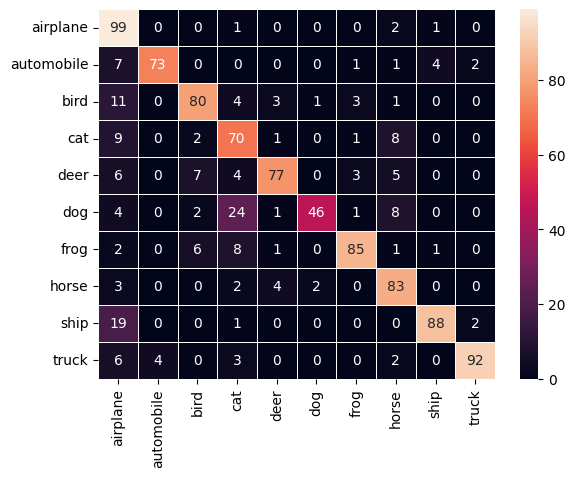

In [49]:
analysis(resnet, X_unattacked_train*255, y_train)

# Analyze Resnet with Attacked Images

16/16 [==============================] - 24s 2s/step
Test Statistics:
              precision    recall  f1-score   support

           0       0.30      0.90      0.45        50
           1       0.81      0.73      0.77        63
           2       0.29      0.47      0.36        43
           3       0.33      0.46      0.39        46
           4       0.50      0.10      0.17        50
           5       0.56      0.38      0.45        40
           6       0.82      0.17      0.28        53
           7       0.74      0.51      0.60        49
           8       0.56      0.45      0.50        44
           9       0.82      0.56      0.67        55

    accuracy                           0.48       493
   macro avg       0.57      0.47      0.46       493
weighted avg       0.59      0.48      0.47       493



Confusion Matrix:


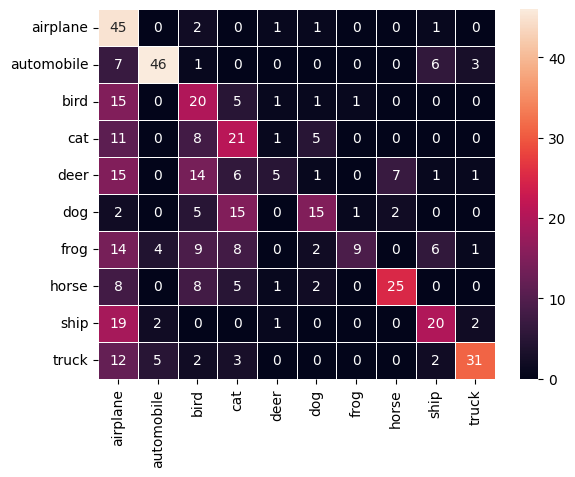

In [50]:
analysis(resnet, X_attacked_test*255, y_test)

# Training Code for counter adversarial models (if needed)

In [57]:
def create_fully_conv_denoising_autoencoder(input_shape, should_log = False):

    model = Sequential()

    model.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu', input_shape = input_shape))
    model.add(layers.BatchNormalization()) # H, W, 16
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding='same', activation = 'relu'))
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    model.add(layers.BatchNormalization()) # H/2, W/2, 32
    model.add(layers.Conv2DTranspose(32, kernel_size = 3, activation="relu", strides=2, padding="same"))
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    model.add(layers.BatchNormalization()) # H, W, 16
    model.add(layers.Conv2D(filters = input_shape[2], kernel_size = 1, strides = 1, padding='same', activation = 'sigmoid'))

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 500, decay_rate = 0.5)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

    if should_log:
        model.summary()

    return model


''' Create denoising autoencoder model that uses fully connected layers '''
def create_fully_conn_denoising_autoencoder(input_shape, should_log = False):

    model = Sequential()

    input_size = 1
    for val in input_shape:
        input_size *= val

    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 128, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units = input_size, activation = 'sigmoid'))
    model.add(layers.Reshape(input_shape))

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001, decay_steps = 1000, decay_rate = 0.5)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

    if should_log:
        model.summary()

    return model


''' Create generative adversarial denoising autoencoder model that uses fully convolutional layers in the
autoencoder followed by a discriminator that also uses convolutional layers '''
def create_GAN_denoising_autoencoder(input_shape, should_log = False):

    autoencoder = Sequential()
    autoencoder.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu', input_shape = input_shape))
    autoencoder.add(layers.BatchNormalization()) # H, W, 16
    autoencoder.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding='same', activation = 'relu'))
    autoencoder.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    autoencoder.add(layers.BatchNormalization()) # H/2, W/2, 32
    autoencoder.add(layers.Conv2DTranspose(32, kernel_size = 3, activation="relu", strides=2, padding="same"))
    autoencoder.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
    autoencoder.add(layers.BatchNormalization()) # H, W, 16
    autoencoder.add(layers.Conv2D(filters = input_shape[2], kernel_size = 1, strides = 1, padding='same', activation = 'sigmoid'))

    if should_log:
        autoencoder.summary()

    discriminator = Sequential()
    discriminator.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation = layers.LeakyReLU(), input_shape = input_shape))
    discriminator.add(layers.BatchNormalization()) # H, W, 16
    discriminator.add(layers.Dropout(0.5))
    discriminator.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding='same', activation = layers.LeakyReLU()))
    discriminator.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation = layers.LeakyReLU()))
    discriminator.add(layers.BatchNormalization()) # H/2, W/2, 32
    discriminator.add(layers.Dropout(0.5))
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(units = 1, activation = 'sigmoid'))

    if should_log:
        discriminator.summary()

    return autoencoder, discriminator


''' Function used to calculate loss values for generative adversarial denoising autoencoder model '''
def get_GAN_denoising_autoencoder_losses(unattacked_images, denoised_images, denoised_disc_output, unattacked_disc_output, mse, binary_cross_entropy):

    # Calculate autoencoder loss (sum of MSE and binary cross entropy from discriminator being fooled
    # into thinking denoised images are unattacked)
    mse_autoencoder_loss = mse(unattacked_images, denoised_images)
    discriminator_output_loss = binary_cross_entropy(tf.ones_like(denoised_disc_output), denoised_disc_output)
    autoencoder_loss = 75 * mse_autoencoder_loss + discriminator_output_loss

    # Calculate discriminator loss (sum of binary cross entropy from correctly classifying unattacked
    # images as unattacked and from correctly classifying denoised images as denoised)
    unattacked_discriminator_loss = binary_cross_entropy(tf.ones_like(unattacked_disc_output), unattacked_disc_output)
    denoised_discriminator_loss = binary_cross_entropy(tf.zeros_like(denoised_disc_output), denoised_disc_output)
    discriminator_loss = unattacked_discriminator_loss + denoised_discriminator_loss

    return autoencoder_loss, discriminator_loss


''' Function used by TensorFlow to train the generative adversarial denoising autoencoder for a single step;
credit: https://www.tensorflow.org/tutorials/generative/dcgan '''
@tf.function
def train_GAN_denoising_autoencoder_step(attacked_images, unattacked_images, autoencoder, discriminator, mse, binary_cross_entropy, autoencoder_optimizer, discriminator_optimizer):

    # Perform training step
    with tf.GradientTape() as autoencoder_tape, tf.GradientTape() as discriminator_tape:
        denoised_images = autoencoder(attacked_images, training=True)

        denoised_disc_output = discriminator(denoised_images, training=True)
        unattacked_disc_output = discriminator(unattacked_images, training=True)

        autoencoder_loss, discriminator_loss = get_GAN_denoising_autoencoder_losses(unattacked_images, denoised_images, denoised_disc_output, unattacked_disc_output, mse, binary_cross_entropy)

    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    gradients_of_autoencoder = autoencoder_tape.gradient(autoencoder_loss, autoencoder.trainable_variables)
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))


''' Function used to train generative adversarial denoising autoencoder model;
credit: https://www.tensorflow.org/tutorials/generative/dcgan '''
def train_GAN_denoising_autoencoder(attacked_images_train, unattacked_images_train, attacked_images_val, unattacked_images_val, num_epochs, batch_size, autoencoder, discriminator):

    # Init loss functions from Keras
    mse = keras.losses.MeanSquaredError()
    binary_cross_entropy = keras.losses.BinaryCrossentropy()

    # Init Adam optimizers for both autoencoder and generator
    autoencoder_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    # Calculate number of batches per epoch
    num_batches_per_epoch = int(attacked_images_train.shape[0] / batch_size)

    # Train for given number of epochs
    autoencoder_losses_train = []
    discriminator_losses_train = []
    autoencoder_losses_val = []
    discriminator_losses_val = []
    for epoch in range(num_epochs):

        print('Starting epoch ' + str(epoch+1) + '/' + str(num_epochs))
        
        # Train one step for each batch in a single epoch
        for _ in range(num_batches_per_epoch):

            # Randomly select batch of batch_size samples from training data
            batch_rand_img_inds = np.random.randint(0, attacked_images_train.shape[0], batch_size)
            attacked_images_batch = attacked_images_train[batch_rand_img_inds]
            unattacked_images_batch = unattacked_images_train[batch_rand_img_inds]

            # Perform training step on current batch of attacked and unattacked images
            train_GAN_denoising_autoencoder_step(attacked_images_batch, unattacked_images_batch, autoencoder, discriminator, mse, binary_cross_entropy, autoencoder_optimizer, discriminator_optimizer)
            
        # Calculate and print losses for the epoch for all training data
        denoised_images_train = autoencoder(attacked_images_train, training = False)
        denoised_disc_output_train = discriminator(denoised_images_train, training = False)
        unattacked_disc_output_train = discriminator(unattacked_images_train, training = False)
        autoencoder_loss_train, discriminator_loss_train = get_GAN_denoising_autoencoder_losses(unattacked_images_train, denoised_images_train, denoised_disc_output_train, unattacked_disc_output_train, mse, binary_cross_entropy)

        print('    autoencoder_loss_train: ' + str(float(autoencoder_loss_train)) + ' - discriminator_loss_train: ' + str(float(discriminator_loss_train)))
        autoencoder_losses_train.append(autoencoder_loss_train)
        discriminator_losses_train.append(discriminator_loss_train)

        # Calculate and print losses for the epoch for all validation data
        denoised_images_val = autoencoder(attacked_images_val, training = False)
        denoised_disc_output_val = discriminator(denoised_images_val, training = False)
        unattacked_disc_output_val = discriminator(unattacked_images_val, training = False)
        autoencoder_loss_val, discriminator_loss_val = get_GAN_denoising_autoencoder_losses(unattacked_images_val, denoised_images_val, denoised_disc_output_val, unattacked_disc_output_val, mse, binary_cross_entropy)

        print('    autoencoder_loss_val: ' + str(float(autoencoder_loss_val)) + ' - discriminator_loss_val: ' + str(float(discriminator_loss_val)))
        autoencoder_losses_val.append(autoencoder_loss_val)
        discriminator_losses_val.append(discriminator_loss_val)
    
    return autoencoder_losses_train, discriminator_losses_train, autoencoder_losses_val, discriminator_losses_val


In [58]:
num_epochs = 1000
# conv = create_fully_conv_denoising_autoencoder(X_attacked[0].shape)
# conv.fit(X_attacked_train, X_unattacked_train, epochs = num_epochs, batch_size = 256, shuffle = True, validation_data = (X_attacked_test, X_unattacked_test))
# conv.save('./trained_fully_conv')

# connect = create_fully_conn_denoising_autoencoder(X_attacked[0].shape)
# connect.fit(X_attacked_train, X_unattacked_train, epochs = num_epochs, batch_size = 256, shuffle = True, validation_data = (X_attacked_test, X_unattacked_test))
# connect.save('./trained_fully_con')

autoencoder, discriminator = create_GAN_denoising_autoencoder(X_attacked[0].shape)
autoencoder_losses_train, discriminator_losses_train, autoencoder_losses_val, discriminator_losses_val = train_GAN_denoising_autoencoder(X_attacked_train, X_unattacked_train, X_attacked_test, X_unattacked_test, num_epochs, 256, autoencoder, discriminator)
gan = autoencoder
# history = gan.fit(X_attacked_train, X_unattacked_train, epochs = num_epochs, batch_size = 256, shuffle = True, validation_data = (X_attacked_test, X_unattacked_test))
gan.save('./trained_gan')

Epoch 1/1000
4/4 [==============================] - 3s 406ms/step - loss: 0.0548 - val_loss: 0.0914
Epoch 2/1000
4/4 [==============================] - 1s 363ms/step - loss: 0.0172 - val_loss: 0.2186
Epoch 3/1000
4/4 [==============================] - 1s 366ms/step - loss: 0.0137 - val_loss: 0.2282
Epoch 4/1000
4/4 [==============================] - 1s 369ms/step - loss: 0.0113 - val_loss: 0.2259
Epoch 5/1000
4/4 [==============================] - 1s 380ms/step - loss: 0.0092 - val_loss: 0.2440
Epoch 6/1000
4/4 [==============================] - 1s 378ms/step - loss: 0.0080 - val_loss: 0.2428
Epoch 7/1000
4/4 [==============================] - 1s 378ms/step - loss: 0.0071 - val_loss: 0.2344
Epoch 8/1000
4/4 [==============================] - 1s 375ms/step - loss: 0.0065 - val_loss: 0.2187
Epoch 9/1000
4/4 [==============================] - 1s 370ms/step - loss: 0.0060 - val_loss: 0.2074
Epoch 10/1000
4/4 [==============================] - 1s 365ms/step - loss: 0.0056 - val_loss: 0.1830

INFO:tensorflow:Assets written to: ./trained_fully_conv\assets


INFO:tensorflow:Assets written to: ./trained_fully_conv\assets


Epoch 1/1000
4/4 [==============================] - 1s 69ms/step - loss: 0.0635 - val_loss: 0.0785
Epoch 2/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0555 - val_loss: 0.1355
Epoch 3/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.0498 - val_loss: 0.2053
Epoch 4/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0462 - val_loss: 0.2451
Epoch 5/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.0437 - val_loss: 0.2553
Epoch 6/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0417 - val_loss: 0.2452
Epoch 7/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.0402 - val_loss: 0.2273
Epoch 8/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0386 - val_loss: 0.2067
Epoch 9/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0371 - val_loss: 0.1802
Epoch 10/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0360 - val_loss: 0.1575
Epoch 11/

INFO:tensorflow:Assets written to: ./trained_fully_con\assets


INFO:tensorflow:Assets written to: ./trained_fully_con\assets


Starting epoch 1/1000
    autoencoder_loss_train: 5.459406852722168 - discriminator_loss_train: 1.37445867061615
    autoencoder_loss_val: 5.385638236999512 - discriminator_loss_val: 1.3772220611572266
Starting epoch 2/1000
    autoencoder_loss_train: 5.4573493003845215 - discriminator_loss_train: 1.3716609477996826
    autoencoder_loss_val: 5.3835530281066895 - discriminator_loss_val: 1.3748302459716797
Starting epoch 3/1000
    autoencoder_loss_train: 5.455262660980225 - discriminator_loss_train: 1.3688380718231201
    autoencoder_loss_val: 5.38144063949585 - discriminator_loss_val: 1.3723931312561035
Starting epoch 4/1000
    autoencoder_loss_train: 5.454345703125 - discriminator_loss_train: 1.3660216331481934
    autoencoder_loss_val: 5.380526542663574 - discriminator_loss_val: 1.3699169158935547
Starting epoch 5/1000
    autoencoder_loss_train: 5.4541826248168945 - discriminator_loss_train: 1.3632856607437134
    autoencoder_loss_val: 5.380392074584961 - discriminator_loss_val: 1.

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.